MỞ DỮ LIỆU

In [11]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [12]:
!pwd

/content


In [13]:
!ls /content/drive/MyDrive/Dataflow/train.csv
!ls /content/drive/MyDrive/Dataflow/test.csv

/content/drive/MyDrive/Dataflow/train.csv
/content/drive/MyDrive/Dataflow/test.csv


In [14]:
import pandas as pd
train_df = pd.read_csv(r"/content/drive/MyDrive/Dataflow/train.csv")
test_df = pd.read_csv(r"/content/drive/MyDrive/Dataflow/test.csv")


In [15]:
print(train_df.dtypes)

ProductID      int64
Date          object
Zip            int64
Units          int64
Revenue      float64
COGS         float64
dtype: object


In [16]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = train_df.sort_values(by='Date', ascending=True)
train_df.reset_index(drop=True, inplace=True)
train_df.head(10)

,ProductID,Date,Zip,Units,Revenue,COGS
0,631,2010-07-04,50801,1,4280.85,4393.864440
1,1041,2010-07-04,11777,1,11651.85,5941.278315
2,1484,2010-07-04,15025,1,849.24,900.279324
3,396,2010-07-04,94566,1,10769.85,9854.412750
4,396,2010-07-04,27614,1,10706.85,9796.767750
5,396,2010-07-04,81401,1,10706.85,9796.767750
6,596,2010-07-04,60177,1,9320.85,5685.718500
7,1041,2010-07-04,56334,1,11651.85,5941.278315
8,2054,2010-07-04,61109,1,6551.37,6273.591912
9,1230,2010-07-04,77657,1,6299.37,3995.690391


In [17]:
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df = test_df.sort_values(by='Date', ascending=True)
test_df.reset_index(drop=True, inplace=True)
test_df.head(10)

,ProductID,Date,Zip,Units,Revenue,COGS
0,1059,2021-01-01,50208,1,2046.87,1094.461389
1,403,2021-01-01,32135,1,13851.81,7786.102401
2,506,2021-01-01,29607,1,14993.37,14029.296309
3,2280,2021-01-01,19063,1,2425.50,2378.687850
4,688,2021-01-01,11572,1,6740.37,5150.990754
5,2036,2021-01-01,89113,1,2582.37,2723.625639
6,1137,2021-01-01,95051,1,10205.37,5739.500088
7,563,2021-01-01,80004,1,9449.37,10324.381662
8,1009,2021-01-01,91604,1,1619.10,1009.185030
9,1177,2021-01-01,50135,1,3023.37,3162.445020


In [18]:
#Xử lí các dữ liệu bị lặp
duplicates = train_df.duplicated().sum()
print(f'Tổng số dữ liệu bị lặp: {duplicates}')
if duplicates > 0:
    train_df = train_df.drop_duplicates()
    print('Đã xử lí các dữ liệu bị lặp.')

Tổng số dữ liệu bị lặp: 36
Đã xử lí các dữ liệu bị lặp.


In [19]:
#Xử lí các dữ liệu thiếu
missing_values = train_df.isnull().sum()
print(f'Tổng số các dữ liệu bị thiếu: \n{missing_values}')
print(missing_values[missing_values > 0])

Tổng số các dữ liệu bị thiếu: 
ProductID    0
Date         0
Zip          0
Units        0
Revenue      0
COGS         0
dtype: int64
Series([], dtype: int64)


In [20]:
#Xử lí các dữ liệu thiếu
missing_values = test_df.isnull().sum()
print(f'Tổng số các dữ liệu bị thiếu: \n{missing_values}')
print(missing_values[missing_values > 0])

Tổng số các dữ liệu bị thiếu: 
ProductID     0
Date          0
Zip           0
Units         0
Revenue      41
COGS          0
dtype: int64
Revenue    41
dtype: int64


In [21]:
# Xóa tất cả các dòng có giá trị thiếu ở cột 'Revenue'
test_df = test_df.dropna(subset=['Revenue'])

# Kiểm tra lại số lượng giá trị bị thiếu
missing_values = test_df['Revenue'].isnull().sum()
print(f'Số lượng giá trị thiếu sau khi xử lý: {missing_values}')


Số lượng giá trị thiếu sau khi xử lý: 0


In [22]:
# Tổng hợp doanh thu theo ngày
train_df = train_df.groupby('Date')['Revenue'].sum().reset_index()
test_df = test_df.groupby('Date')['Revenue'].sum().reset_index()

In [23]:
# Bỏ các cột không cần thiết trong tập dữ liệu nếu chúng tồn tại
columns_to_drop = ['ProductID', 'Zip', 'Units', 'COGS']
train_df = train_df.drop(columns=[col for col in columns_to_drop if col in train_df.columns])
test_df = test_df.drop(columns=[col for col in columns_to_drop if col in test_df.columns])

In [25]:
train_df.to_csv('sarima.csv', index=False)
test_df.to_csv('sarima_test.csv', index=False)

In [27]:
sarima_df = pd.read_csv(r"/content/sarima.csv", index_col= 'Date', parse_dates = True)
sarima_test_df = pd.read_csv(r"/content/sarima_test.csv", index_col= 'Date', parse_dates = True)

In [28]:
sarima_df.head()

,Revenue
Date,
2010-07-04,1765391.67
2010-07-05,1425986.10
2010-07-06,302463.00
2010-07-07,1047787.65
2010-07-08,771811.74


In [29]:
sarima_test_df.head()

,Revenue
Date,
2021-01-01,189558.81
2021-01-02,280406.70
2021-01-03,317656.08
2021-01-04,373463.37
2021-01-05,31120.11


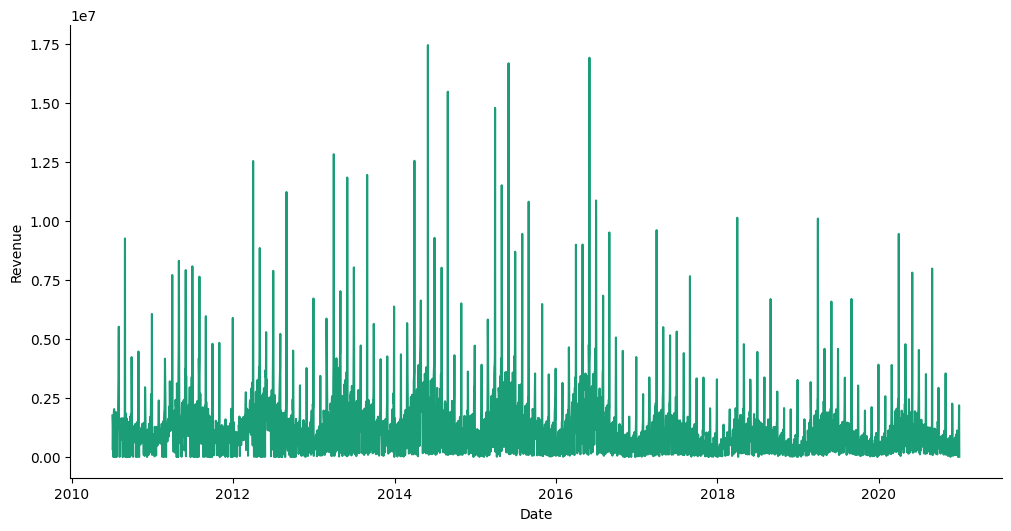

In [ ]:
# @title Date vs Revenue

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Revenue']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = arima_df.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Revenue')

In [30]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, log_transform=False):

    # Loại bỏ giá trị NaN nếu có
    series = series.dropna()

    # Áp dụng log-transform nếu dữ liệu có giá trị dương
    if log_transform and (series > 0).all():
        series = np.log(series)

    # Kiểm tra tính dừng bằng ADF test
    result = adfuller(series, autolag='AIC')

    # Làm tròn p-value đến 3 chữ số thập phân
    p_value = round(result[1], 3)
    test_statistic = result[0]
    lags_used = result[2]
    critical_values = result[4]

    # Quyết định tính dừng
    decision = "Stationary" if p_value < 0.05 else "Non-Stationary"

    # Đóng gói kết quả
    output_dict = {
        "Test Statistic": test_statistic,
        "p-value": p_value,
        "Lags Used": lags_used,
        "Decision": decision
    }

    # Thêm giá trị tới hạn
    for key, value in critical_values.items():
        output_dict[f"Critical Value ({key})"] = value

    return pd.Series(output_dict, name="ADF Test")

In [32]:
# Chạy kiểm tra ADF trên dữ liệu Revenue
result_adf = check_stationarity(sarima_df['Revenue'], log_transform=True)
print(result_adf)

Test Statistic           -3.566387
p-value                      0.006
Lags Used                       30
Decision                Stationary
Critical Value (1%)      -3.432125
Critical Value (5%)      -2.862324
Critical Value (10%)     -2.567187
Name: ADF Test, dtype: object


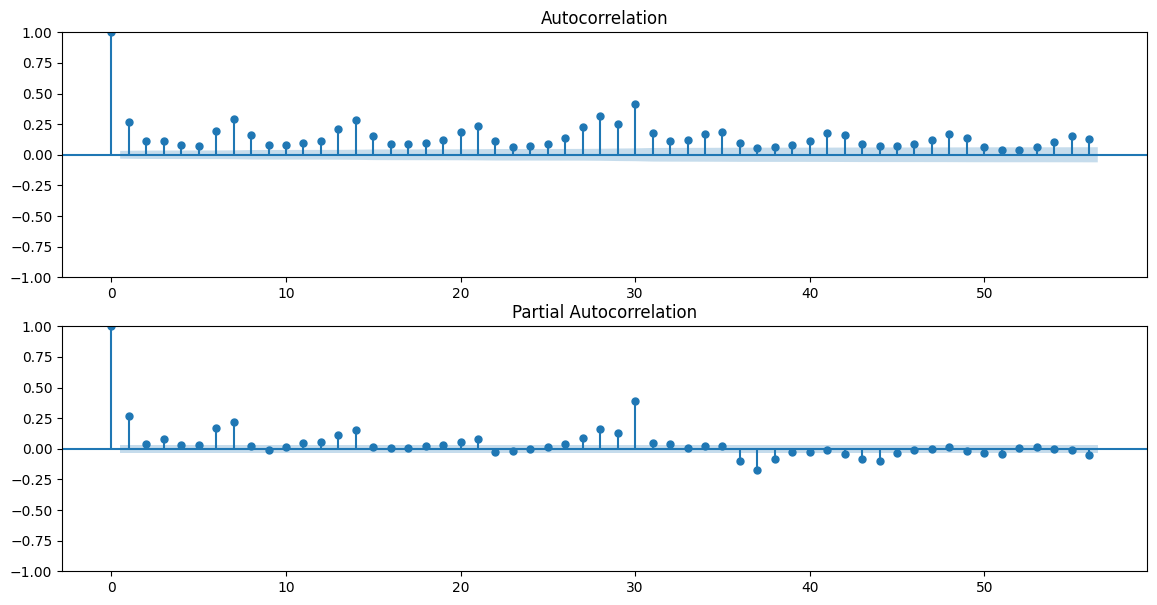

In [35]:
# Vẽ Autocorrelation Plots
fig, ax = plt.subplots(2, figsize=(14,7))
plot_acf(sarima_df['Revenue'], ax=ax[0], lags=56)
plot_pacf(sarima_df['Revenue'], ax=ax[1], lags=56)
plt.show()

In [60]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# fit the model
sarima_model = SARIMAX(sarima_df,
                       order=(5,0,0),
                       seasonal_order=(5, 0, 0, 12),
                       enforce_invertibility=False,
                       enforce_stationarity=False)

sarima_fit = sarima_model.fit()

In [41]:
print(sarima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            Revenue   No. Observations:                 3718
Model:             SARIMAX(5, 0, 0)x(5, 0, 0, 12)   Log Likelihood              -56550.204
Date:                            Mon, 24 Feb 2025   AIC                         113122.409
Time:                                    16:34:03   BIC                         113190.645
Sample:                                         0   HQIC                        113146.709
                                           - 3718                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1483      0.011     13.600      0.000       0.127       0.170
ar.L2         -0.0326      0.019   

In [63]:
# prompt: code để đọc chỉ số đánh giá mô hình sarima MAPE R2 RMSE

import numpy as np
# Accessing the model evaluation metrics from the SARIMAX results summary
# The summary() method provides various metrics, but we'll extract the relevant ones.

# AIC, BIC, Log-likelihood can be extracted from sarima_fit.summary()
# You might need to parse the summary text to find the specific metrics.

# Example: Extracting AIC, BIC and Loglikelihood values (replace with your actual parsing method).
# The exact location in the summary object will depend on the version of the library.

# AIC = sarima_fit.aic  # Access AIC directly if available
# BIC = sarima_fit.bic  # Access BIC directly if available
# Loglikelihood = sarima_fit.llf  # Access log-likelihood directly if available


# Predictions and evaluation (MAPE, R2, RMSE)
predictions = sarima_fit.get_forecast(steps=len(sarima_test_df))
predicted_mean = predictions.predicted_mean

# Calculate MAPE
mape = np.mean(np.abs((sarima_test_df['Revenue'] - predicted_mean) / sarima_test_df['Revenue'])) * 100

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(sarima_test_df['Revenue'], predicted_mean))

# Calculate R-squared (R2) - you may need to use a different library or method here.
# The SARIMAX model summary might not directly provide R-squared.

# Print evaluation metrics
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")

from sklearn.metrics import r2_score
r2 = r2_score(sarima_test_df['Revenue'], predicted_mean)
print(f'R-squared (R2): {r2}')



MAPE: nan%
RMSE: 1328340.58
R-squared (R2): -0.7491372665755636
